In [49]:
from fastai.vision.all import *
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm,wandb,albumentations as A
from albumentations.pytorch import ToTensorV2

import cv2,torchvision
from timm.loss import SoftTargetCrossEntropy
from timm.data.mixup import Mixup
from timm.scheduler import CosineLRScheduler
from timm.optim.optim_factory import create_optimizer_v2
from timm.models import safe_model_name, set_fast_norm
from timm.models.layers import create_classifier, SelectAdaptivePool2d
from tqdm.auto import tqdm

import pytorch_pfn_extras as ppe
import pytorch_pfn_extras.training.extensions as extensions

In [2]:
set_seed(42); set_fast_norm()
warnings.filterwarnings('ignore')

## Config

In [3]:
DATA_PATH = Path('/data/')
CSV_PATH = DATA_PATH/'train.csv'
IMAGE_FOLDER = DATA_PATH/'train'

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}

MODEL = "beit_base_patch16_224"
BS = 32
SZ = 224
EP = 16
LR = 2e-5
WD = 1e-8

MODEL_FOLDER = Path("/runs/NB_EXP_V2_001/")
KERNEL_TYPE = f"{MODEL}_{SZ}_bs{BS}_ep{EP}_lr{str(LR).replace('-','')}_wd{str(WD).replace('-','')}_mixup"

In [4]:
all_df = pd.read_csv(CSV_PATH)
all_df.head()

folds = all_df.copy()
fold_splits = []

Fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["label"])):
    fold_splits.append(val_index)
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
folds.to_csv('/data/train_folds.csv', index=False)
folds.head()

,seed_id,view,image,label,fold
0,0,top,train/00000.png,broken,0
1,1,bottom,train/00001.png,pure,3
2,3,top,train/00003.png,broken,2
3,4,top,train/00004.png,pure,3
4,5,top,train/00005.png,discolored,4


## Define Dataset

In [5]:
class LoadImagesAndLabels(torch.utils.data.Dataset):
    
    def __init__(self, df, transforms, mode='train'):
        self.df = df
        self.transforms = transforms
        self.mode = mode
        
    def __len__(self): return len(self.df)
    
    def __getitem__(self,index):
        row = self.df.iloc[index]
        img_path = str(DATA_PATH/row.image)
        
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)
        
        if self.transforms is not None:
            img = self.transforms(image=img)['image']
        
        if self.mode == 'test':
            return img
            
        label = torch.tensor(labels_class_map[row.label]).long()
        return img, label

## Augmentations

In [45]:
TRAIN_AUG = A.Compose([
    A.RandomResizedCrop(SZ, SZ, scale=(0.72, 1.0), p=1.0),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(rotate_limit=360, border_mode=0, p=0.75),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    A.Blur(p=0.5),
    A.CoarseDropout(max_height=int(32*(SZ/512)), max_width=int(32*(SZ/512)), p=0.75),
    A.Normalize(),
    ToTensorV2(),
])

VALID_AUG = A.Compose([
    A.SmallestMaxSize(max_size=SZ + 16, p=1.0),
    A.CenterCrop(height=SZ, width=SZ, p=1.0),
    A.Normalize(),
    ToTensorV2(),
])

## Visualization

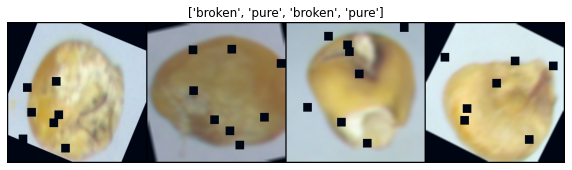

In [7]:
dataset_show = LoadImagesAndLabels(folds, TRAIN_AUG, mode='train')
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=4)
img,target = next(iter(loader_show))

grid = torchvision.utils.make_grid(img, normalize=True, padding=2)
grid = grid.permute(1, 2, 0)
show_image(grid, figsize=(10,8), title=[labels_class_map_rev[x] for x in target.numpy()]);

## Model

In [8]:
def get_corn_model(model_name, pretrained=True, **kwargs):
    model = timm.create_model(model_name, pretrained=pretrained, **kwargs)
    model.reset_classifier(num_classes=len(LABELS))
    return model

## LRScheduler

In [9]:
#!pip -q install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
#from warmup_scheduler import GradualWarmupScheduler

In [10]:
# class GradualWarmupSchedulerV2(GradualWarmupScheduler):
#     def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
#         super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
#     def get_lr(self):
#         if self.last_epoch > self.total_epoch:
#             if self.after_scheduler:
#                 if not self.finished:
#                     self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
#                     self.finished = True
#                 return self.after_scheduler.get_lr()
#             return [base_lr * self.multiplier for base_lr in self.base_lrs]
#         if self.multiplier == 1.0:
#             return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
#         else:
#             return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

## Train & Validation Function

In [11]:
def training_loop(
    manager:ppe.training.ExtensionsManager, model:nn.Module, loader:Iterable,
    loss_fn: Callable, optimizer: torch.optim.Optimizer, 
    lr_scheduler:torch.optim.lr_scheduler._LRScheduler=None, mixup_fn:Callable=None, 
    grad_scaler: torch.cuda.amp.GradScaler=None):
    
    while not manager.stop_trigger:
        model.train()
        
        for _, (input, target) in enumerate(loader):
            with manager.run_iteration():
                input, target = input.cuda(), target.cuda()
                input, target = mixup_fn(input, target)
                
                optimizer.zero_grad()
                with torch.cuda.amp.autocast(enabled=True):
                    output = model(input)
                    loss = loss_fn(output, target)
                
                grad_scaler.scale(loss).backward() 
                grad_scaler.step(optimizer)
                grad_scaler.update()
                
                if lr_scheduler is not None:
                    lr_scheduler.step()
                
                ppe.reporting.report({'train/loss': loss.item()})
                
                
def validate(model:nn.Module, input:Tensor, target:Tensor, loss_fn:Callable):
    """ 
    The extension loops over the iterator in order to drive the evaluator 
    progress bar and reporting averages
    """
    model.eval()
    input, target = input.cuda(), target.cuda()
    output = model(input)
    # Final result will be average of averages of the same size
    test_loss = loss_fn(output, target).item()
    ppe.reporting.report({'val/loss': test_loss})
    pred = output.argmax(dim=1, keepdim=True)

    correct = pred.eq(target.view_as(pred)).sum().item()
    ppe.reporting.report({'val/acc': correct / len(input)})

## Run!

In [12]:
def run(fold):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        print()
        print('*' * 100)
        print(f'Training fold {fold}')
        print('*' * 100)
        
        torch.backends.cudnn.benchmark = True
        
        print("Transform = ")
        for trans in (TRAIN_AUG, VALID_AUG):
            print(" - - - - - - - - - - ")
            for t in trans.transforms:
                print(t)
        print("---------------------------")
        
        dataset_train = LoadImagesAndLabels(folds.query('fold!=@fold'), transforms=TRAIN_AUG, mode="train")
        dataset_valid = LoadImagesAndLabels(folds.query('fold==@fold'), transforms=VALID_AUG, mode="valid")

        print(f"TRAIN: {len(dataset_train)} | VALID: {len(dataset_valid)}")
        
        loader_train = torch.utils.data.DataLoader(dataset_train, BS, num_workers=8, shuffle=True, drop_last=True)
        loader_valid = torch.utils.data.DataLoader(dataset_valid, BS*2, num_workers=8, shuffle=False)

        model = get_corn_model(MODEL, pretrained=True, drop_path_rate=0.1, attn_drop_rate=0.0)
        model.cuda()

        optimizer = create_optimizer_v2(model, "adamw", lr=LR, weight_decay=WD, layer_decay=0.85)
        
        num_train_steps = len(loader_train)*EP
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_train_steps)
        
        train_loss_fn = SoftTargetCrossEntropy()
        valid_loss_fn = nn.CrossEntropyLoss()

        grad_scaler = torch.cuda.amp.GradScaler()

        mixup = Mixup(mixup_alpha=0.4, 
                      cutmix_alpha=0.0,
                      prob=0.6, 
                      switch_prob=0.0, 
                      label_smoothing=0.0, 
                      num_classes=len(LABELS))

        my_extensions = [
            extensions.LRScheduler(lr_scheduler, trigger=(1, "iteration")),
            extensions.Evaluator(loader_valid, model, eval_func=lambda input, target: validate(model, input, target, valid_loss_fn)),
            extensions.observe_lr(optimizer=optimizer),
            extensions.ProgressBar(update_interval=1),
            extensions.LogReport(filename=f"log_{KERNEL_TYPE}_CV_{fold}.json", format="json")
        ]

        manager = ppe.training.ExtensionsManager(
            model, optimizer, max_epochs=EP, extensions=my_extensions,
            iters_per_epoch=len(loader_train), out_dir=MODEL_FOLDER)

        manager.extend(
            extensions.snapshot(target=model, filename=KERNEL_TYPE + f"_CV_{fold}.pth"),
            trigger=ppe.training.triggers.MaxValueTrigger(key="val/acc", trigger=(1, 'epoch')))

        manager.extend(
            extensions.PrintReport(['epoch', 'iteration', 'lr', 'train/loss', 'val/loss', 'val/acc', 'elapsed_time']),
            trigger=(1, 'epoch'))
        
        print(f"Start training for {EP} epochs")

        training_loop(
            manager, model, loader_train, loss_fn=train_loss_fn, 
            optimizer=optimizer, mixup_fn=mixup, grad_scaler=grad_scaler)

In [13]:
for fold_idx in range(5): 
    run(fold_idx)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


****************************************************************************************************
Training fold 0
****************************************************************************************************
Transform = 
 - - - - - - - - - - 
RandomResizedCrop(always_apply=False, p=1.0, height=224, width=224, scale=(0.72, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1)
Transpose(always_apply=False, p=0.5)
HorizontalFlip(always_apply=False, p=0.5)
VerticalFlip(always_apply=False, p=0.5)
ShiftScaleRotate(always_apply=False, p=0.75, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-360, 360), interpolation=1, border_mode=0, value=None, mask_value=None, rotate_method='largest_box')
RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0

HTML(value='')

CPU: 1913/197/3436 MB | GPU: 2472/3894/3558 MB | Time 0:14:27.101 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


****************************************************************************************************
Training fold 1
****************************************************************************************************
Transform = 
 - - - - - - - - - - 
RandomResizedCrop(always_apply=False, p=1.0, height=224, width=224, scale=(0.72, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1)
Transpose(always_apply=False, p=0.5)
HorizontalFlip(always_apply=False, p=0.5)
VerticalFlip(always_apply=False, p=0.5)
ShiftScaleRotate(always_apply=False, p=0.75, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-360, 360), interpolation=1, border_mode=0, value=None, mask_value=None, rotate_method='largest_box')
RandomBr

HTML(value='')

CPU: 328/161/3764 MB | GPU: 1794/4099/3560 MB | Time 0:14:28.647 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


****************************************************************************************************
Training fold 2
****************************************************************************************************
Transform = 
 - - - - - - - - - - 
RandomResizedCrop(always_apply=False, p=1.0, height=224, width=224, scale=(0.72, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1)
Transpose(always_apply=False, p=0.5)
HorizontalFlip(always_apply=False, p=0.5)
VerticalFlip(always_apply=False, p=0.5)
ShiftScaleRotate(always_apply=False, p=0.75, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-360, 360), interpolation=1, border_mode=0, value=None, mask_value=None, rotate_method='largest_box')
RandomBri

HTML(value='')

CPU: 0/161/3765 MB | GPU: 1792/4096/3560 MB | Time 0:14:29.952 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


****************************************************************************************************
Training fold 3
****************************************************************************************************
Transform = 
 - - - - - - - - - - 
RandomResizedCrop(always_apply=False, p=1.0, height=224, width=224, scale=(0.72, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1)
Transpose(always_apply=False, p=0.5)
HorizontalFlip(always_apply=False, p=0.5)
VerticalFlip(always_apply=False, p=0.5)
ShiftScaleRotate(always_apply=False, p=0.75, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-360, 360), interpolation=1, border_mode=0, value=None, mask_value=None, rotate_method='largest_box')
RandomBrigh

HTML(value='')

CPU: 3/158/3768 MB | GPU: 1792/4096/3560 MB | Time 0:14:29.539 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


****************************************************************************************************
Training fold 4
****************************************************************************************************
Transform = 
 - - - - - - - - - - 
RandomResizedCrop(always_apply=False, p=1.0, height=224, width=224, scale=(0.72, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1)
Transpose(always_apply=False, p=0.5)
HorizontalFlip(always_apply=False, p=0.5)
VerticalFlip(always_apply=False, p=0.5)
ShiftScaleRotate(always_apply=False, p=0.75, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-360, 360), interpolation=1, border_mode=0, value=None, mask_value=None, rotate_method='largest_box')
RandomBrigh

HTML(value='')

CPU: -9/159/3759 MB | GPU: 1792/4096/3560 MB | Time 0:14:29.338 | (Consumed/Peaked/Used Total)


In [52]:
folds_val_score = []
for fold in range(5):
    CHECKPOINT = MODEL_FOLDER/(KERNEL_TYPE + f"_CV_{fold}.pth")
    
    model = get_corn_model(MODEL, pretrained=False)
    model.load_state_dict(torch.load(CHECKPOINT))
    model.eval()
    model.cuda()
    print(f'=> load from : {CHECKPOINT}')
    
    dataset_valid = LoadImagesAndLabels(folds.query('fold==@fold'), transforms=VALID_AUG, mode="valid")
    loader_valid = torch.utils.data.DataLoader(dataset_valid, BS*2, num_workers=8, shuffle=False)
    
    preds, targs = [],[]
    for input,target in tqdm(loader_valid, total=len(loader_valid), dynamic_ncols=True):
        with torch.cuda.amp.autocast(), torch.no_grad():
            input = input.cuda()
            
            output  = model(input)
            output += model(torch.flip(input, dims=(3,)))
            output += model(torch.flip(input, dims=(2,)))
            output += model(torch.flip(input, dims=(2,3)))
            
        preds.append(output.data.cpu())
        targs.append(target)
    
    preds = torch.cat(preds)
    targs = torch.cat(targs)
    
    acc = accuracy(preds, targs).item()
    print(f"* Accuracy : {acc}")
    print()
        
    folds_val_score.append(acc)
    
    
print()
print('*' * 100)
print(f'Run summary: ')
print('*' * 100)
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

=> load from : /runs/NB_EXP_V2_001/beit_base_patch16_224_224_bs32_ep16_lr2e05_wd1e08_mixup_CV_0.pth


  0%|                                                                                                         …

* Accuracy : 0.8153577446937561

=> load from : /runs/NB_EXP_V2_001/beit_base_patch16_224_224_bs32_ep16_lr2e05_wd1e08_mixup_CV_1.pth


  0%|                                                                                                         …

* Accuracy : 0.8174520134925842

=> load from : /runs/NB_EXP_V2_001/beit_base_patch16_224_224_bs32_ep16_lr2e05_wd1e08_mixup_CV_2.pth


  0%|                                                                                                         …

* Accuracy : 0.8041201233863831

=> load from : /runs/NB_EXP_V2_001/beit_base_patch16_224_224_bs32_ep16_lr2e05_wd1e08_mixup_CV_3.pth


  0%|                                                                                                         …

* Accuracy : 0.8226256966590881

=> load from : /runs/NB_EXP_V2_001/beit_base_patch16_224_224_bs32_ep16_lr2e05_wd1e08_mixup_CV_4.pth


  0%|                                                                                                         …

* Accuracy : 0.8208798766136169


****************************************************************************************************
Run summary: 
****************************************************************************************************
folds score:  [0.81536, 0.81745, 0.80412, 0.82263, 0.82088]
Avg: 0.81609
Std: 0.00650
